In [14]:
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Load Spotify credentials from .env file
load_dotenv()

# Access Spotify API keys from environment variables
SPOTIFY_CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID")
SPOTIFY_CLIENT_SECRET = os.getenv("SPOTIFY_CLIENT_SECRET")
SPOTIFY_REDIRECT_URI = os.getenv("SPOTIFY_REDIRECT_URI")

# Set up SpotifyOAuth with required scopes
scope = "user-read-currently-playing user-read-playback-state"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=SPOTIFY_CLIENT_ID,
    client_secret=SPOTIFY_CLIENT_SECRET,
    redirect_uri=SPOTIFY_REDIRECT_URI,
    scope=scope
))

# Get the currently playing track
current_playback = sp.current_playback()

# Check if there's a song currently playing
if current_playback and current_playback['is_playing']:
    track = current_playback['item']
    track_name = track['name']
    artist_name = track['artists'][0]['name']
    album_name = track['album']['name']
    progress_ms = current_playback['progress_ms'] // 1000  # Convert ms to seconds
    duration_ms = track['duration_ms'] // 1000  # Convert ms to seconds

    print(f"Now Playing: {track_name} by {artist_name}")
    print(f"Album: {album_name}")
    print(f"Progress: {progress_ms}s / {duration_ms}s")
else:
    print("No song is currently playing.")


Now Playing: HUMANOID / SHAKE IT UP by Turnstile
Album: GLOW ON
Progress: 3s / 69s


In [20]:
sp.audio_analysis(track_id='spotify:track:4hVbecfxAWbMsb56lxGshM')

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/4hVbecfxAWbMsb56lxGshM with Params: {} returned 403 due to None


SpotifyException: http status: 403, code: -1 - https://api.spotify.com/v1/audio-analysis/4hVbecfxAWbMsb56lxGshM:
 None, reason: None

Currently playing album cover URL: https://i.scdn.co/image/ab67616d0000b273e9c3c16b480e1c5a84d7b188
Album cover downloaded into memory.
Dominant color (RGB): (15, 114, 145)
Color palette (RGB): [(15, 114, 145), (5, 6, 13), (214, 231, 216), (102, 184, 191), (39, 163, 196)]


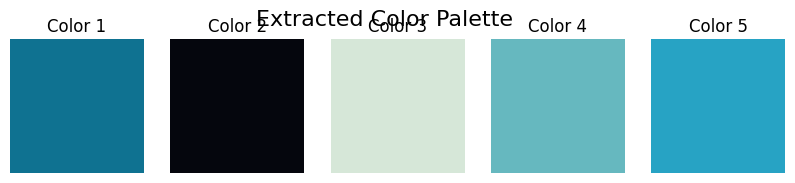

In [2]:
import os
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import requests
from io import BytesIO
from colorthief import ColorThief
import matplotlib.pyplot as plt

# ===========================
# Configuration and Setup
# ===========================

# Load environment variables from .env file
load_dotenv()

# Retrieve credentials from environment variables
SPOTIFY_CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID")
SPOTIFY_CLIENT_SECRET = os.getenv("SPOTIFY_CLIENT_SECRET")
SPOTIFY_REDIRECT_URI = os.getenv("SPOTIFY_REDIRECT_URI")

# Verify that required credentials are present
if not SPOTIFY_CLIENT_ID or not SPOTIFY_CLIENT_SECRET or not SPOTIFY_REDIRECT_URI:
    raise ValueError("Missing one of the required environment variables: "
                     "SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET, SPOTIFY_REDIRECT_URI.")

# Define the necessary scope
scope = "user-read-currently-playing"

# Initialize the Spotipy client with OAuth
auth_manager = SpotifyOAuth(
    client_id=SPOTIFY_CLIENT_ID,
    client_secret=SPOTIFY_CLIENT_SECRET,
    redirect_uri=SPOTIFY_REDIRECT_URI,
    scope=scope,
    cache_path=".cache-spotify"  # Ensure this is in your .gitignore
)
sp = spotipy.Spotify(auth_manager=auth_manager)

# ===========================
# Retrieve Currently Playing Track
# ===========================

# Get the currently playing track
current_track = sp.current_user_playing_track()

if current_track and current_track.get('item'):
    # Extract the album images
    images = current_track['item']['album']['images']
    # Typically images[0] is the largest image
    if images:
        album_cover_url = images[0]['url']
        print("Currently playing album cover URL:", album_cover_url)
        
        # ===========================
        # Download the Album Cover Image into Memory
        # ===========================
        try:
            response = requests.get(album_cover_url)
            response.raise_for_status()  # Raise an error for bad status codes
            image_data = response.content
            image_stream = BytesIO(image_data)
            print("Album cover downloaded into memory.")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading the album cover: {e}")
            exit(1)
        
        # ===========================
        # Extract Color Palette from In-Memory Image
        # ===========================
        try:
            color_thief = ColorThief(image_stream)
            # Get the dominant color
            dominant_color = color_thief.get_color(quality=1)
            # Get a palette of 5 colors
            palette = color_thief.get_palette(color_count=5, quality=1)
            print("Dominant color (RGB):", dominant_color)
            print("Color palette (RGB):", palette)
        except Exception as e:
            print(f"Error extracting color palette: {e}")
            exit(1)
        
        # ===========================
        # Visualize the Color Palette
        # ===========================
        try:
            # Create a figure to display the palette
            plt.figure(figsize=(10, 2))
            for i, color in enumerate(palette):
                plt.subplot(1, len(palette), i + 1)
                plt.imshow([[color]])
                plt.axis('off')
                plt.title(f"Color {i+1}")
            plt.suptitle("Extracted Color Palette", fontsize=16)
            plt.show()
        except Exception as e:
            print(f"Error visualizing the color palette: {e}")
    else:
        print("No album images found for the currently playing track.")
else:
    print("No track is currently playing.")


In [5]:
import sys
import os

# Get the absolute path to the parent directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Define the path to the spotify folder
spotify_dir = os.path.join(parent_dir, 'spotify')

# Add the spotify directory to sys.path
if spotify_dir not in sys.path:
    sys.path.append(spotify_dir)

print("Spotify directory added to sys.path:", spotify_dir)


Spotify directory added to sys.path: /Users/charly/SpotifyDMX/SpotifyDMX/source/spotify


In [6]:
import importlib.util

# Path to the album_colors.py file
album_colors_path = os.path.join(spotify_dir, 'album_colors.py')

spec = importlib.util.spec_from_file_location("album_colors", album_colors_path)
album_colors = importlib.util.module_from_spec(spec)
spec.loader.exec_module(album_colors)

print("album_colors module imported successfully.")


album_colors module imported successfully.


In [7]:
# Retrieve the color vector
colors = album_colors.get_current_album_colors()

# Display the colors
if colors:
    print("\nRetrieved Album Colors:")
    print(f"Dominant Color: {colors['dominant_color']}")
    print(f"Color Palette: {colors['palette']}")
else:
    print("Failed to retrieve album colors.")


Currently playing album cover URL: https://i.scdn.co/image/ab67616d0000b27327ba726c68fe38bab876d5b6
Album cover downloaded into memory.
Dominant color (RGB): (229, 68, 24)
Color palette (RGB): [(229, 68, 24), (59, 166, 58), (183, 204, 136), (220, 144, 98), (230, 161, 142)]

Retrieved Album Colors:
Dominant Color: (229, 68, 24)
Color Palette: [(229, 68, 24), (59, 166, 58), (183, 204, 136), (220, 144, 98), (230, 161, 142)]
